In [10]:
from dotenv import load_dotenv
load_dotenv("../.env") # load the HF_TOKEN stored in .env file

True

In [11]:
!nvidia-smi # check for the nvidia systems management interface

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mon Oct 21 23:03:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:01:00.0 Off |                  Off |
| 30%   43C    P8              24W / 230W |   1674MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
!pip install -U -q accelerate transformers bitsandbytes
!pip install -q git+https://github.com/huggingface/diffusers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
import torch
import gc

def flush():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_peak_memory_stats()

flush()

In [14]:
from transformers import T5EncoderModel

ckpt_4bit_id = "sayakpaul/flux.1-dev-nf4-pkg"

text_encoder_2_4bit = T5EncoderModel.from_pretrained(
    ckpt_4bit_id,
    subfolder="text_encoder_2"
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [15]:
from diffusers import FluxPipeline, FluxTransformer2DModel

ckpt_id = "black-forest-labs/FLUX.1-dev"

pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder_2=text_encoder_2_4bit,
    transformer=None,
    vae=None,
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


In [16]:
prompt = "a red panda in mountain on a skateboard with a cap on head"

with torch.no_grad():
  print("Encoding prompts")
  prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt(
      prompt = prompt, prompt_2=None, max_sequence_length=256
  )

pipeline = pipeline.to("cpu")
del pipeline
flush()

print(f"prompt_embeds shape: {prompt_embeds.shape}")
print(f"pooled_prompt_embeds shape: {pooled_prompt_embeds.shape}")

Encoding prompts


prompt_embeds shape: torch.Size([1, 256, 4096])
pooled_prompt_embeds shape: torch.Size([1, 768])


In [17]:
transformer_4bit = FluxTransformer2DModel.from_pretrained(ckpt_4bit_id, subfolder="transformer")
pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder=None,
    text_encoder_2=None,
    tokenizer=None,
    tokenizer_2=None,
    transformer=transformer_4bit,
    torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 46.31it/s]


#### Model Running ####


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


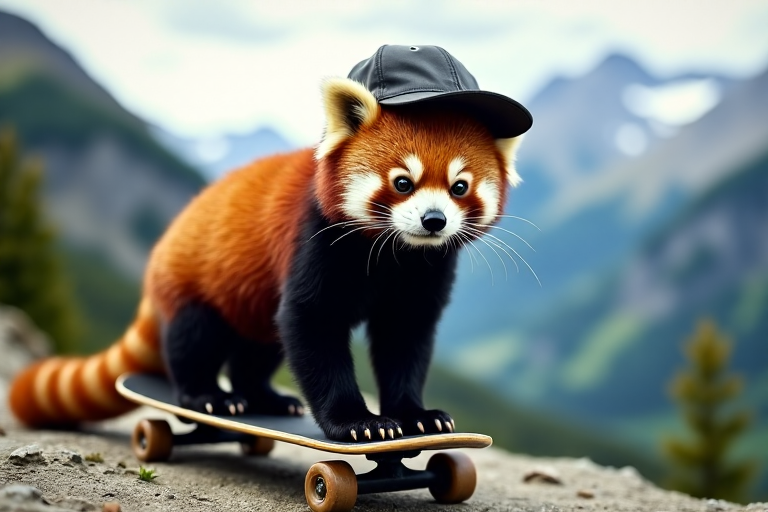

In [18]:
print("#### Model Running ####")
height, width = 512, 768
images = pipeline(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=pooled_prompt_embeds,
    num_inference_steps=50,
    guidance_scale=5.5,
    height=height,
    width=width,
    output_type="pil").images

images[0].save("output.png")

from PIL import Image
Image.open("output.png")